In [1]:
import numpy as np, matplotlib.pyplot as plt
import scipy.optimize as optimize
from astropy.io import ascii as asc
from analysis.composite_errors import random_pdf
from analysis.MC_contours import contours, confidence

FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'
CUTOFF_SIGMA = 4.0
CUTOFF_MASS = 6.0

In [2]:
# reading in data generated by EBV_corrections.py
corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',guess=False,
                Reader=asc.FixedWidthTwoLine)
zspec0 = np.array(corr_tbl['zspec0'])
no_spectra  = np.where((zspec0 <= 0) | (zspec0 > 9))[0]
yes_spectra = np.where((zspec0 >= 0) & (zspec0 < 9))[0]

stlr_mass = np.array(corr_tbl['stlr_mass'])
filts = np.array(corr_tbl['filt'])
sfr = np.array(corr_tbl['met_dep_sfr'])
dust_corr_factor = np.array(corr_tbl['dust_corr_factor'])
filt_corr_factor = np.array(corr_tbl['filt_corr_factor'])
nii_ha_corr_factor = np.array(corr_tbl['nii_ha_corr_factor'])
corr_sfrs = sfr+filt_corr_factor+nii_ha_corr_factor+dust_corr_factor

# defining a flux sigma and mass cutoff
good_sig_iis = np.where((corr_tbl['flux_sigma'] >= CUTOFF_SIGMA) & (stlr_mass >= CUTOFF_MASS))[0]
n = len(good_sig_iis)

In [13]:
sigmas = corr_tbl['meas_errs'][good_sig_iis].data
mass = stlr_mass[good_sig_iis]
sfrs = corr_sfrs[good_sig_iis]

z_sp = zspec0[good_sig_iis]
badz_iis = np.array([x for x in range(len(z_sp)) if z_sp[x] < 0 or z_sp[x] > 9])
filt_lambda_list = {'NB704':7045.0, 'NB711':7126.0, 'NB816':8152.0, 'NB921':9193.0, 'NB973':9749.0}
ffs = filts[good_sig_iis]
for ff in filt_lambda_list.keys():
    badf_match = np.where(ffs[badz_iis] == ff)[0]
    z_sp[badz_iis[badf_match]] = (filt_lambda_list[ff]/6562.8) - 1
    
mz_data = np.vstack([mass, z_sp]).T

In [4]:
eqn_str = r'$\log(SFR) = \alpha \log(M) + \beta z + \gamma$'
def func(data, a, b, c):
    return a*data[:,0] + b*data[:,1] + c

eqn0 = r'$\log(SFR) = \alpha \log(M) + \beta$'
def func0(data, a, b):
    return a*data + b

### the plot

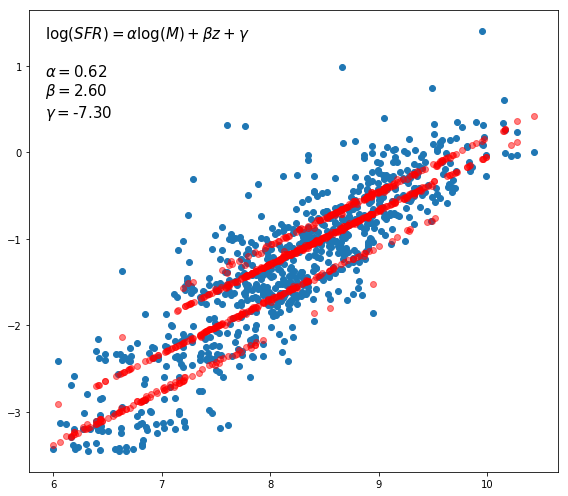

In [5]:
f, ax = plt.subplots()
# axarr = np.ndarray.flatten(axes)
f.set_size_inches(8,7)

ax.plot(mass, sfrs, 'o')
params00, pcov = optimize.curve_fit(func, mz_data, sfrs)
perr = np.sqrt(np.diag(pcov))
ax.plot(mass, func(mz_data, *params00), 'ro', alpha=0.5)
ax.text(0.03,0.97,eqn_str+
    '\n\n'+r'$\alpha=$'+'%.2f'%params00[0]+ #r'$\pm$'+'%.3f'%perr[0]+
    '\n'+r'$\beta=$'+'%.2f'%params00[1]+ #r'$\pm$'+'%.3f'%perr[1]+
    '\n'+r'$\gamma=$'+'%.2f'%params00[2], #+r'$\pm$'+'%.3f'%perr[2],
    transform=ax.transAxes,fontsize=15,ha='left',va='top')

plt.tight_layout()
plt.show()

## contours: log SFR = \alpha log M + \gamma

In [6]:
delta_sfrs = corr_tbl['meas_errs'].data[good_sig_iis]

num_iters = 10000
seed = 132089
sfrs_pdf = random_pdf(sfrs, delta_sfrs, seed_i=seed, n_iter=num_iters)

np.random.seed(12376)

alpha_arr = np.array([])
gamma_arr = np.array([])

for i in range(num_iters):
    s_arr = sfrs_pdf[:,i]

    params, pcov = optimize.curve_fit(func0, mass, s_arr)
    alpha_arr = np.append(alpha_arr, params[0])
    gamma_arr = np.append(gamma_arr, params[1])

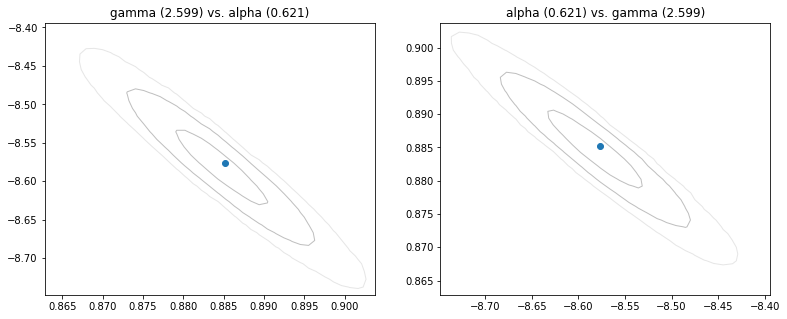

In [7]:
f, axes = plt.subplots(1,2)
params_arr = [alpha_arr, gamma_arr]
lbl_arr = ['alpha', 'gamma']

for i, ax, const_arr, lbl in zip(range(2), axes, params_arr, lbl_arr):
    j = (i+1)%2

    xsize=0.001 if np.std(params_arr[i]) < 0.01 else 0.01
    ysize=0.001 if np.std(params_arr[j]) < 0.01 else 0.01

    x_final, y_final, hist2d, sig_levels = contours(params_arr[i], params_arr[j], xsize, ysize, three_sig=True)
    ax.contour(x_final, y_final, hist2d, levels=sig_levels, colors=('0.90','0.75','0.75'))
    ax.scatter(np.median(params_arr[i]), np.median(params_arr[j]))
    
    ax.set_title(lbl_arr[j]+' (%.3f)'%params00[j]+' vs. '+lbl_arr[i]+' (%.3f)'%params00[i])
    
f.set_size_inches(13,5)

## contours: log SFR = \alpha log M + \beta z + \gamma

In [65]:
print len([x for x in range(len(good_sig_iis)) if 'Ha-NB704' in corr_tbl['NAME0'][good_sig_iis][x]
          and good_sig_iis[x] in no_spectra])
print len([x for x in range(len(good_sig_iis)) if 'Ha-NB704' in corr_tbl['NAME0'][good_sig_iis][x]
          and 'Ha-NB711' not in corr_tbl['NAME0'][good_sig_iis][x] and good_sig_iis[x] in no_spectra])
print
print len([x for x in range(len(good_sig_iis)) if 'Ha-NB711' in corr_tbl['NAME0'][good_sig_iis][x]
          and good_sig_iis[x] in no_spectra])
print len([x for x in range(len(good_sig_iis)) if 'Ha-NB711' in corr_tbl['NAME0'][good_sig_iis][x]
          and 'Ha-NB704' not in corr_tbl['NAME0'][good_sig_iis][x] and good_sig_iis[x] in no_spectra])
print
print len([x for x in range(len(good_sig_iis)) if 'Ha-NB711' in corr_tbl['NAME0'][good_sig_iis][x]
          and 'Ha-NB704' in corr_tbl['NAME0'][good_sig_iis][x] and good_sig_iis[x] in no_spectra])

46
44

34
32

2


In [8]:
delta_sfrs = corr_tbl['meas_errs'].data[good_sig_iis]
assert len(mass) == len(sfrs) == len(delta_sfrs) == len(z_sp)

num_iters = 10000
seed = 132089
sfrs_pdf = random_pdf(sfrs, delta_sfrs, seed_i=seed, n_iter=num_iters)

np.random.seed(12376)

alpha_arr = np.array([])
beta_arr = np.array([])
gamma_arr = np.array([])

mz_ndarr = np.vstack([mass, z_sp]).T

for i in range(num_iters):
    s_arr = sfrs_pdf[:,i]

    params, pcov = optimize.curve_fit(func, mz_ndarr, s_arr)
    alpha_arr = np.append(alpha_arr, params[0])
    beta_arr = np.append(beta_arr, params[1])
    gamma_arr = np.append(gamma_arr, params[2])

In [9]:
# f, axes = plt.subplots(1,3)
# for i, ax, const_arr, lbl in zip(range(3), axes, [alpha_arr, beta_arr, gamma_arr], ['alpha', 'beta', 'gamma']):
#     ax.hist(const_arr, bins=50)
#     ax.axvline(params00[i], c='r', ls='--')
#     ax.set_title(lbl+'= %.2f'%params00[i])
#     print '%.3f'%params00[i], '(sample mean: %.3f)'%np.mean(const_arr)
#     print '\t (-%.3f'%confidence(const_arr)[0]+', +%.3f'%confidence(const_arr)[1]+')'
    
# f.set_size_inches(17,5)

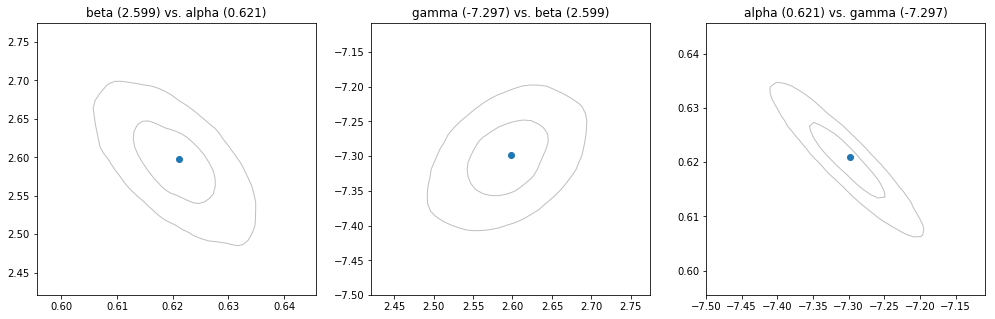

In [10]:
f, axes = plt.subplots(1,3)
params_arr = [alpha_arr, beta_arr, gamma_arr]
lbl_arr = ['alpha', 'beta', 'gamma']

for i, ax, const_arr, lbl in zip(range(3), axes, params_arr, lbl_arr):
    j = (i+1)%3
    
    xsize=0.001 if np.std(params_arr[i]) < 0.01 else 0.01
    ysize=0.001 if np.std(params_arr[j]) < 0.01 else 0.01
    x_final, y_final, hist2d, sig_levels = contours(params_arr[i], params_arr[j], xsize, ysize)
    ax.contour(x_final, y_final, hist2d, levels=sig_levels, colors=('0.75','0.75','0.75'))
    ax.scatter(np.median(params_arr[i]), np.median(params_arr[j]))
    
    ax.set_title(lbl_arr[j]+' (%.3f)'%params00[j]+' vs. '+lbl_arr[i]+' (%.3f)'%params00[i])
    
f.set_size_inches(17,5)

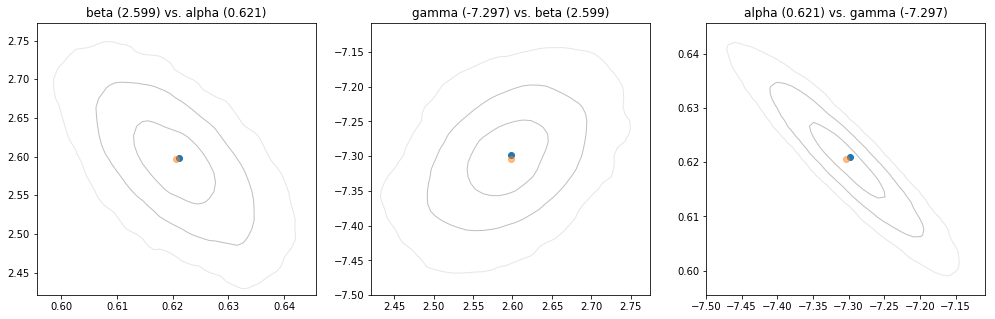

In [11]:
f, axes = plt.subplots(1,3)
params_arr = [alpha_arr, beta_arr, gamma_arr]
lbl_arr = ['alpha', 'beta', 'gamma']

for i, ax, const_arr, lbl in zip(range(3), axes, params_arr, lbl_arr):
    j = (i+1)%3

    if i>0:
        xsize=0.001 if np.std(params_arr[i]) < 0.01 else 0.01
        ysize=0.001 if np.std(params_arr[j]) < 0.01 else 0.01
    else:
        xsize=0.001 if np.std(params_arr[i]) < 0.01 else 0.009
        ysize=0.001 if np.std(params_arr[j]) < 0.01 else 0.012

    x_final, y_final, hist2d, sig_levels = contours(params_arr[i], params_arr[j], xsize, ysize, three_sig=True)
    # ax.contour(x_final, y_final, hist2d, levels=sig_levels, colors=('0.75','0.75','0.75'))
    ax.contour(x_final, y_final, hist2d, levels=sig_levels, colors=('0.90','0.75','0.75'))
    ax.scatter(np.median(params_arr[i]), np.median(params_arr[j]))
    ax.scatter(np.mean(x_final), np.mean(y_final), alpha=0.5)
    
    
    ax.set_title(lbl_arr[j]+' (%.3f)'%params00[j]+' vs. '+lbl_arr[i]+' (%.3f)'%params00[i])
    
f.set_size_inches(17,5)

In [12]:
# for every fit i have an alpha beta gamma
# what happens is that we're gonna generate a grid of each of these three parameters
# a v b, b v g, g v a  (2D grid)
# get total num of galaxies in a given "bin" (must define based on density of sources)
# compute the bin with the highest peak 
# say the # in one bin is 010, then go down to 99. "give me all the galxies with 99 and above, total that up, then 98"
# we know there are 10,000 galaxies so we know that 68% is 6,800 galaxies. want a fn'l form of "what is the peak value of a given bin suc hthat you encompass 68%"
# contours plot, levels = that maximum
# step down in 2D (and teh distr. might not be a perfect circle bc of correlation)
# take val, subtract off min value, divide off bin size, round to nearest int. 
# then essentially you'll have a list of values and wahtever your binning array is you're gonna have this += 1 and it'll automatically go through and index everything. zero for loops.
# (grid defined by amin/amax, etc)

# code created a 3D dataset
#  np.zeros((30,30))
# slice depedning on which direction you're looking at
# based on what you provide it, it does just x,y, or x,y,z